# NWIS and Plotting

尝试用HyRivers的工具，主要参考：https://github.com/cheginit/HyRiver-examples/blob/main/notebooks/nwis.ipynb

In [4]:
import pandas as pd
import pydaymet as daymet
import pygeohydro as gh
import xarray as xr
from pygeohydro import NWIS, plot

In [5]:
_ = xr.set_options(display_expand_attrs=False)

We can explore the available NWIS stations within a bounding box using ``interactive_map`` function. It returns an interactive map and by clicking on an station some of the most important properties of stations are shown so you can decide which station(s) to choose from.

In [2]:
bbox = (-69.5, 45, -69, 45.5)

In [6]:
nwis_kwds = {"hasDataTypeCd": "dv", "outputDataTypeCd": "dv", "parameterCd": "00060"}
gh.interactive_map(bbox, nwis_kwds=nwis_kwds)

We can get more information about these stations using the `get_info` function from `NWIS` class.

In [7]:
nwis = NWIS()
query = {
    "bBox": ",".join(f"{b:.06f}" for b in bbox),
    "hasDataTypeCd": "dv",
    "outputDataTypeCd": "dv",
}
info_box = nwis.get_info(query)

Now, let's select all the stations that their daily mean streamflow data are available between 2000-01-01 and 2010-12-31.

In [8]:
dates = ("2000-01-01", "2010-12-31")
stations = info_box[
    (info_box.begin_date <= dates[0]) & (info_box.end_date >= dates[1])
].site_no.tolist()

One of the useful information in the database in Hydro-Climatic Data Network - 2009 (HCDN-2009) flag. This flag shows whether the station is natural (True) or affected by human activities (False). If an station is not available in the HCDN dataset `None` is returned.

In [9]:
query = {
    "site": ",".join(stations),
    "hasDataTypeCd": "dv",
    "outputDataTypeCd": "dv",
}
info = nwis.get_info(query, expanded=True)
info.set_index("site_no").hcdn_2009

site_no
01031450           False
01031500            True
01031500            True
01031500            True
01031500            True
451031069185301     None
451105069270801     None
Name: hcdn_2009, dtype: object

We can get the daily mean streamflow for these stations using the ``get_streamflow`` function. This function has a flag to return the data mm/day rather than the default `cms` which is useful for hydrolgy models and plotting hydrologic signatures.

In [10]:
qobs = nwis.get_streamflow(stations, dates, mmd=False)

Dropped 0 stations since they don't have daily mean discharge from 2000-01-01 to 2010-12-31.


In [16]:
type(stations)

list

In [17]:
stations

['01031450',
 '01031500',
 '01031500',
 '01031500',
 '01031500',
 '451031069185301',
 '451105069270801']

In [19]:
type(dates)

tuple

In [20]:
dates

('2000-01-01', '2010-12-31')

In [11]:
qobs

,USGS-01031450,USGS-01031500
dateTime,,
2000-01-01,2.038813,5.974855
2000-01-02,1.840595,5.606736
2000-01-03,1.699011,5.295250
2000-01-04,1.642377,4.898814
2000-01-05,1.670694,5.097032
...,...,...
2010-12-27,4.757230,14.781394
2010-12-28,4.700597,14.611493
2010-12-29,4.615646,13.960205


Then we can use the ``signatures`` function to plot hydrologic signatures of the streamflow. Note that the input time series should be in mm/day. This function has argument, `output`, for saving the plot as a `png` file.

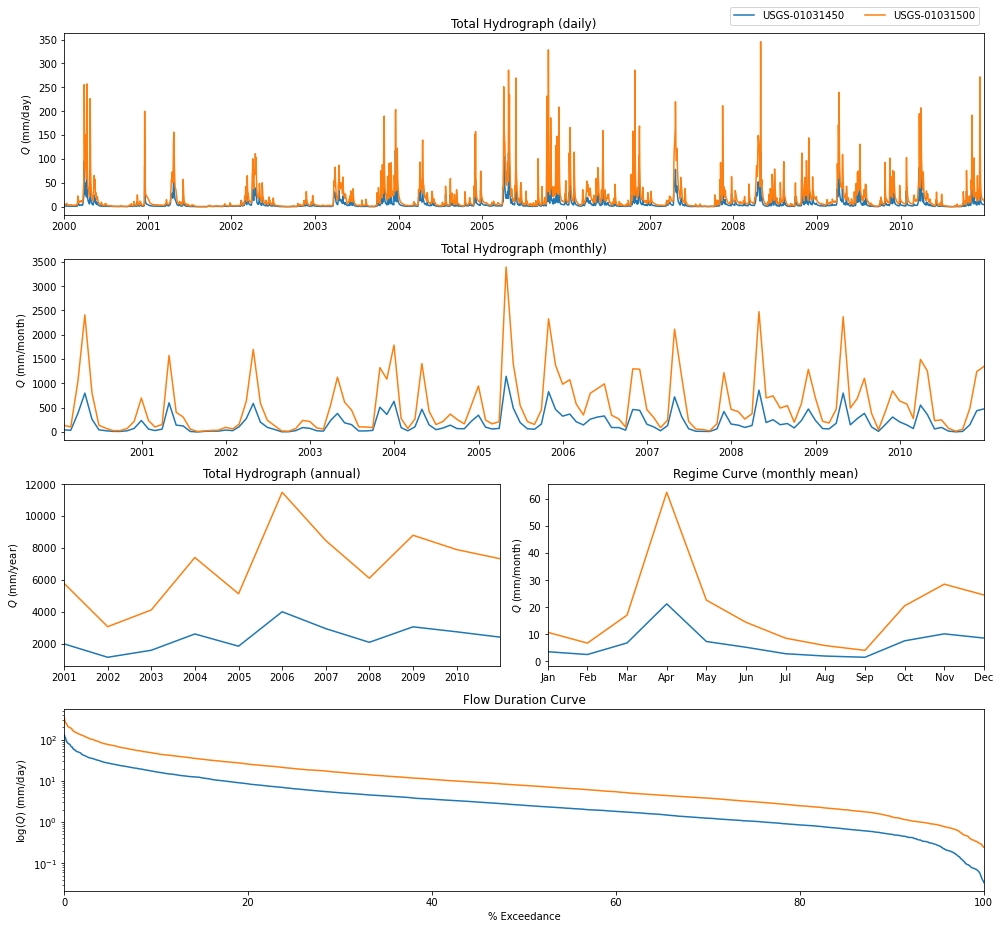

In [13]:
plot.signatures(qobs, output="_static/example_plots_signatures.png")

This function also can show precipitation data as a bar plot. Let's use [PyDaymet](https://github.com/cheginit/pydaymet) to get the precipitation at the NWIS stations location.

In [14]:
sid = "01031500"
coords = tuple(info[info.site_no == sid][["dec_long_va", "dec_lat_va"]].to_numpy()[0])
prcp = daymet.get_byloc(coords, dates, variables="prcp")

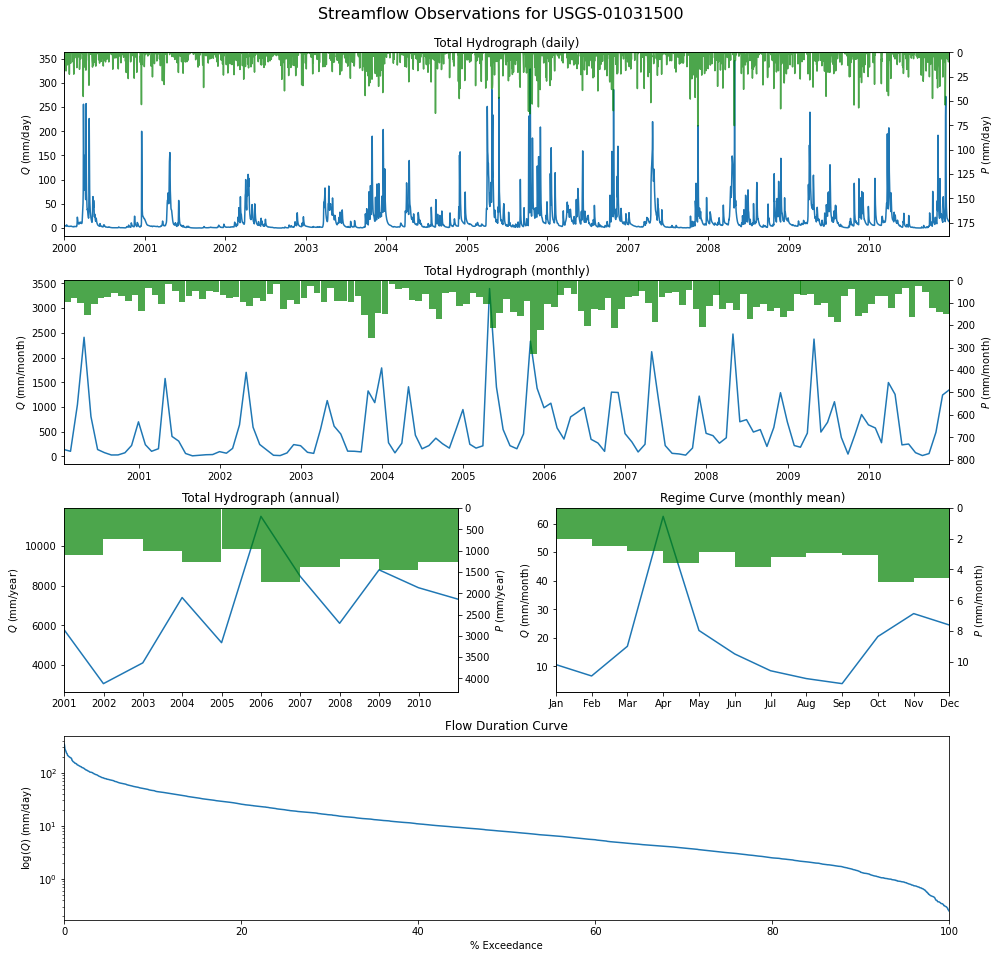

In [15]:
plot.signatures(qobs[f"USGS-{sid}"], prcp, title=f"Streamflow Observations for USGS-{sid}")